## Monte Carlo Simulation of a Geometric Brownian Motion with Jump Diffusion

### Initializing Parameters

In [2]:
import numpy as np
import matplotlib.pyplot as plt

mean_daily_returns = np.array([0.02, 0.03, 0.04]) / 100
cov_matrix = np.array([[0.1, 0.03, 0.05],
                       [0.03, 0.12, 0.04],
                       [0.05, 0.04, 0.15]]) / 10000
# Jump parameters
jump_intensity = np.array([0.05, 0.09, 0.12])  
jump_mean = np.array([0.00, -0.20, 0.10]) / 100  
jump_volatility = np.array([2.00, 3.00, 4.00]) / 100  

### Generate a Geometric Brownian Motion with Jumps

In [3]:
def simulate_correlated_gbm_with_jumps(mean_returns, cov_matrix, initial_values, num_days, jump_intensity, jump_mean, jump_volatility):
    """
    Simulate correlated GBM paths for multiple assets, with jumps.
    """
    num_assets = len(mean_returns)
    chol_decomp = np.linalg.cholesky(cov_matrix)  # Cholesky decomposition for covariance matrix

    # Initialize matrix to store log prices for all assets
    log_prices = np.log(initial_values) * np.ones((num_days, num_assets))

    # Simulate log price paths with jumps
    for t in range(1, num_days):
        # Generate correlated random shocks (from Cholesky decomposition)
        correlated_shocks = chol_decomp @ np.random.normal(0, 1, num_assets)

        # GBM formula for each asset
        drift = mean_returns - 0.5 * np.diag(cov_matrix)  
        diffusion = correlated_shocks  # Cholesky handles scaling the shocks

        # Simulate jumps for each asset individually using Poisson distribution for each asset's intensity
        jumps = np.zeros(num_assets)
        for i in range(num_assets):
            num_jumps = np.random.poisson(jump_intensity[i] * 1)  # Poisson distribution for number of jumps for each asset
            if num_jumps > 0:
                jumps[i] = np.sum(np.random.normal(jump_mean[i], jump_volatility[i], num_jumps))  # Jumps for the asset

        # Apply the jump to the diffusion term for each asset
        diffusion += jumps  # Add jumps to the diffusion process

        log_prices[t] = log_prices[t-1] + drift + diffusion  # Update log prices

    # Convert log-prices back to prices
    return np.exp(log_prices)

### Monte Carlo Simulation

In [4]:
def monte_carlo_simulation_with_jumps(mean_returns, cov_matrix, num_simulations, num_days, weights, initial_values, jump_intensity, jump_mean, jump_volatility):
    """
    Monte Carlo simulation of portfolio paths using correlated GBM with jumps.
    """
    num_assets = len(mean_returns)
    portfolio_simulations = np.zeros((num_simulations, num_days))

    for i in range(num_simulations):
        # Simulate correlated GBM paths with jumps for all assets
        asset_paths = simulate_correlated_gbm_with_jumps(mean_returns, cov_matrix, initial_values, num_days, jump_intensity, jump_mean, jump_volatility)
        # Compute portfolio values at each time step using the weighted sum of asset paths
        portfolio_simulations[i, :] = np.dot(asset_paths, weights)

    return portfolio_simulations

### Plotting the Simulation Results

In [5]:
def plot_simulations(portfolio_simulations, num_days):
    cmap = plt.cm.plasma  # You can change this to any colormap (e.g., 'plasma', 'inferno', etc.)
    colors = cmap(np.linspace(0, 1, portfolio_simulations.shape[0]))
    # Plot individual simulations with different colors for portfolio
    plt.figure(figsize=(12, 6))
    for i in range(portfolio_simulations.shape[0]):
        plt.plot(portfolio_simulations[i, :], color=colors[i], alpha=0.3)
    plt.title('Monte Carlo Simulation of Portfolio Value')
    plt.xlabel('Days')
    plt.ylabel('Portfolio Value')
    plt.show()

    # Calculate daily returns of the simulated portfolio (percentage change)
    daily_returns = np.diff(portfolio_simulations, axis=1) / portfolio_simulations[:, :-1]
    
    # Plot daily returns of the portfolio
    plt.figure(figsize=(12, 6))
    for i in range(portfolio_simulations.shape[0]):
        plt.plot(daily_returns[i, :], color='blue', alpha=0.1)
    plt.title('Daily Returns of Simulated Portfolio')
    plt.xlabel('Days')
    plt.ylabel('Daily Return')
    plt.show()

    # Plot histogram of daily returns of the portfolio
    plt.figure(figsize=(12, 6))
    plt.hist(daily_returns.flatten(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title('Histogram of Daily Returns of Simulated Portfolio with Jumps')
    plt.xlabel('Daily Returns')
    plt.ylabel('Frequency')
    plt.show()

    # Plot distribution of final portfolio values (at last day)
    final_values = portfolio_simulations[:, -1]
    plt.figure(figsize=(12, 6))
    plt.hist(final_values, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title('Distribution of Final Portfolio Values (Day 252)')
    plt.xlabel('Portfolio Value at Day 252')
    plt.ylabel('Frequency')
    plt.show()

    print(f"Mean Final Portfolio Value: {np.mean(final_values):.2f}")
    print(f"Standard Deviation of Final Portfolio Value: {np.std(final_values):.2f}")

### Run the Code

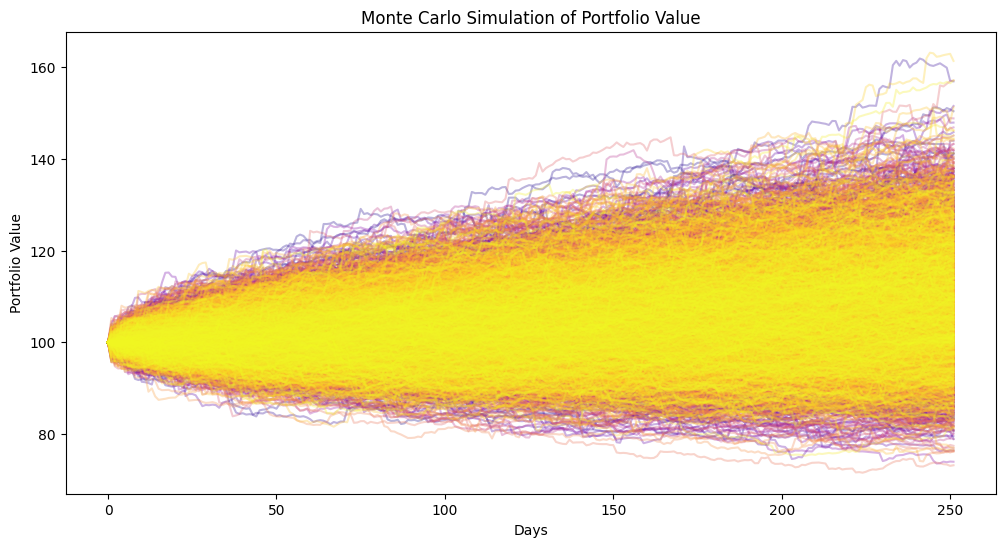

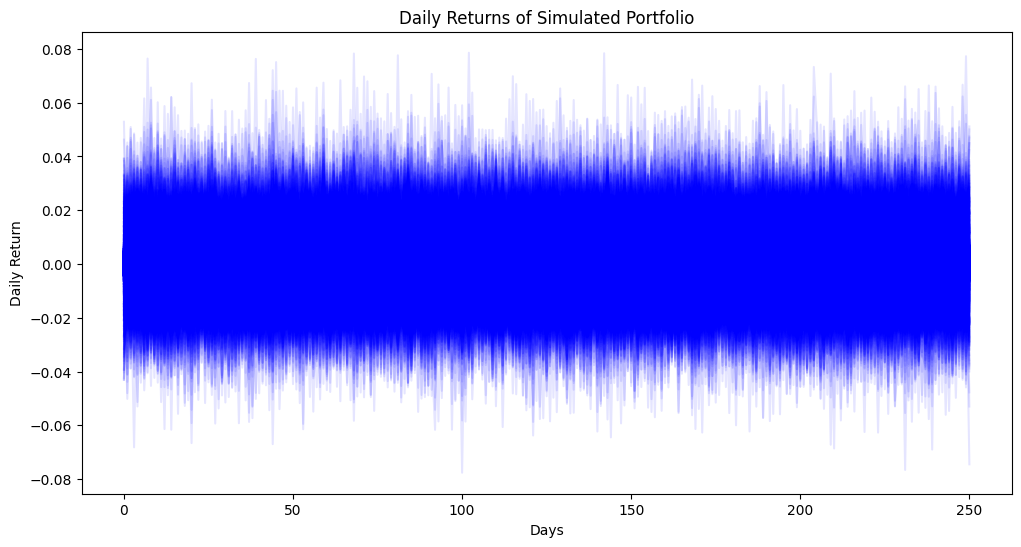

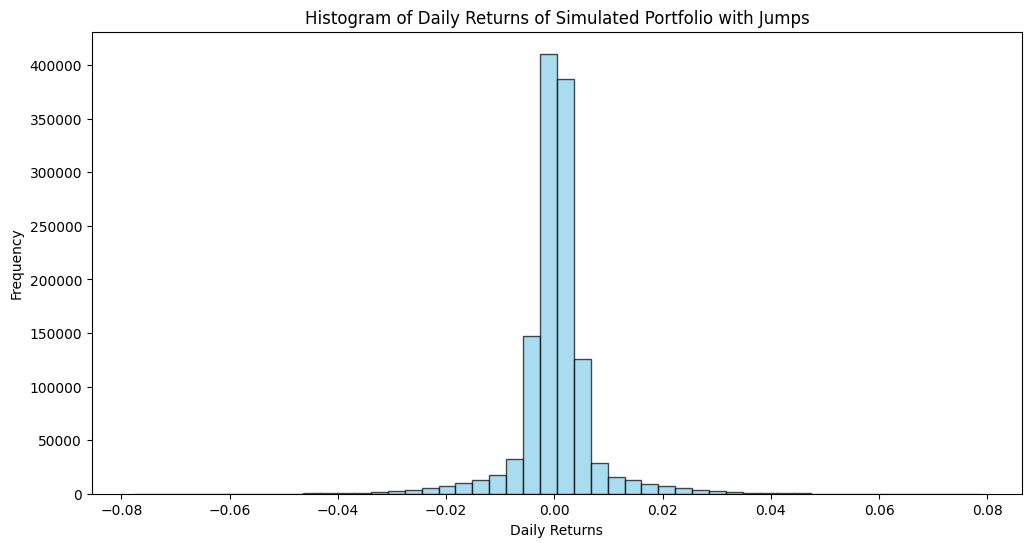

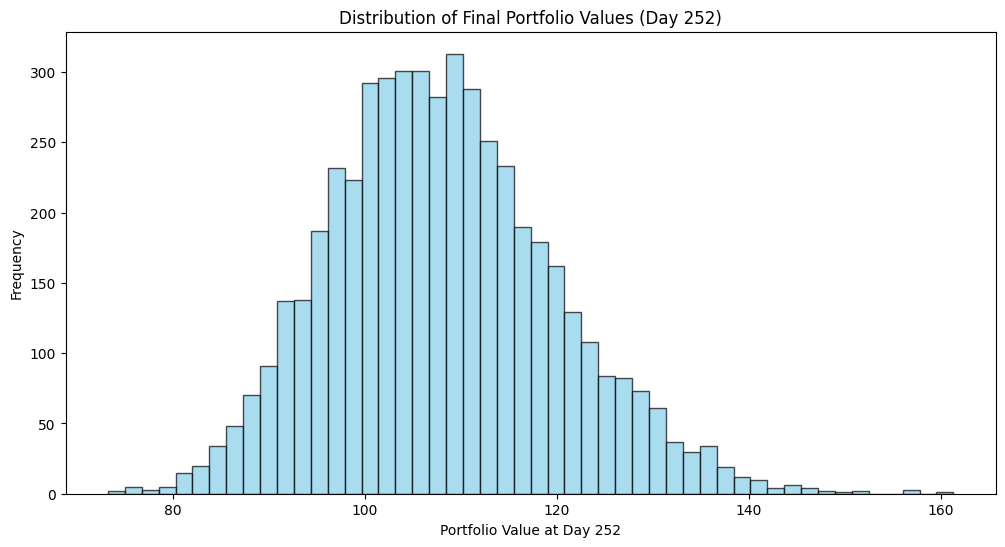

Mean Final Portfolio Value: 108.06
Standard Deviation of Final Portfolio Value: 11.77


In [6]:
def main(mean_returns, cov_matrix, weights, jump_intensity, jump_mean, jump_volatility, num_simulations=5000, num_days=252, initial_values=100, seed=42):
    np.random.seed(seed)
    initial_values = np.ones(len(mean_returns)) * initial_values 
    portfolio_simulations = monte_carlo_simulation_with_jumps(mean_returns, cov_matrix, num_simulations, num_days, weights, initial_values, jump_intensity, jump_mean, jump_volatility)
    plot_simulations(portfolio_simulations, num_days)

# Example usage
if __name__ == "__main__":
    # Portfolio parameters
    weights = np.array([0.2, 0.5, 0.3])

    # Run simulation
    main(mean_daily_returns, cov_matrix, weights, jump_intensity, jump_mean, jump_volatility)